### Install Deps

In [ ]:
# !pip install keras
# !pip install numpy
# !pip install tensorflow-gpu==2.10.0
# !pip install imageio
# !pip install tqdm

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from Seq2Seq import Seq2Seq
from torch.utils.data import DataLoader
from tensorflow import keras

import io
import imageio
from ipywidgets import widgets, HBox
import wandb
from scipy.ndimage import zoom
from tqdm import tqdm
# Use GPU if available

print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [ ]:
# run = wandb.init(project='CloudNowcasting')

## Get Data

In [ ]:
def resize_image(image, new_shape):
    ratio = [n / float(o) for n, o in zip(new_shape, image.shape)]
    return zoom(image, ratio, mode='nearest')


In [4]:
# data_path2 = keras.utils.get_file(
#     "moving_mnist.npy",
#     "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
# )
data_path = "2023-full.npy"
dataset = np.load(data_path)

dataset_resized = []
for i in tqdm(range(len(dataset))):
    dataset_resized.append([])
    for j in range(len(dataset[i])):
        dataset_resized[i].append(resize_image(dataset[i][j], (64, 64)))

dataset = np.array(dataset_resized)
# dataset2 = np.load(data_path2).transpose(1, 0, 2, 3)
                
# Shuffle

np.random.shuffle(dataset)

train_data = dataset[:int(dataset.shape[0]*0.8)]
test_data = dataset[int(dataset.shape[0]*0.2):]

100%|██████████| 718/718 [00:35<00:00, 20.06it/s]


In [5]:

def collate(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(10,20)                     
    return batch[:,:,rand-10:rand], batch[:,:,rand]     


# Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)

# Validation Data Loader
test_loader = DataLoader(test_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)

In [6]:
# Get a batch
input, _ = next(iter(test_loader))

# Reverse process before displaying
input = input.cpu().numpy() * 255.0     

for video in input.squeeze(1)[:3]:          # Loop over videos
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
        display(HBox([widgets.Image(value=gif.getvalue())]))

C:\Users\Sam\AppData\Local\Temp\ipykernel_19720\1512710029.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  batch = torch.tensor(batch).unsqueeze(1)


In [7]:
# The input video frames are grayscale, thus single channel
from torch.optim.lr_scheduler import StepLR
model = Seq2Seq(num_channels=1, num_kernels=64, 
kernel_size=(3, 3), padding=(1, 1), activation="relu", 
frame_size=(64, 64), num_layers=3).to(device)

optim = Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.BCELoss(reduction='sum')
scheduler = StepLR(optim, step_size=10, gamma=0.1)

In [8]:
torch.cuda.empty_cache()

In [ ]:
num_epochs = 100
patience = 7
best_val_loss = float("inf")
epochs_without_improvement = 0

for epoch in range(1, num_epochs+1):
    
    train_loss = 0                                                 
    model.train()                                                  
    for input, target in tqdm(train_loader):  
        output = model(input)                                     
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()                                 
    train_loss /= len(train_loader)                      

    val_loss = 0                                                 
    model.eval()                                                  
    with torch.no_grad():                                          
        for input, target in test_loader:                          
            output = model(input)                                   
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()                                
    val_loss /= len(test_loader)                           
    scheduler.step()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # If the validation loss hasn't improved for 'patience' epochs, stop training
    if epochs_without_improvement == patience:
        print('Stopping early')
        break

    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f}\n".format(
        epoch, train_loss, val_loss))
    # wandb.log({"train_loss": train_loss, "val_loss": val_loss})

In [21]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
def collate_test(batch):

    # Last 10 frames are target
    target = np.array(batch)[:,10:]                     
    
    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)          
    batch = batch / 255.0                             
    batch = batch.to(device)                          
    return batch, target

# Test Data Loader
test_loader = DataLoader(test_data,shuffle=True, 
                         batch_size=10, collate_fn=collate_test)

# Get a batch
batch, target = next(iter(test_loader))
accuracy_list = []
# Initialize output sequence
output = np.zeros(target.shape, dtype=np.uint8)

ground_truth = target[0]
# Loop over timesteps

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode


with torch.no_grad():
    for timestep in range(target.shape[1]):
        print(timestep)
        input = batch[:,:,timestep:timestep+10]   
        output[:,timestep]=(model(input).squeeze(1).cpu() > .5)*255.0
        target[:,timestep] = (target[:,timestep] > .5) * 255
        accuracy = accuracy_score(target[:,timestep].flatten(), output[:,timestep].flatten())
        accuracy_list.append(accuracy)


average_accuracy = sum(accuracy_list) / len(accuracy_list)
print(f'Average accuracy: {average_accuracy}')

0
1
2
3
4
5
6
7
8
9
Average accuracy: 0.7765869140625


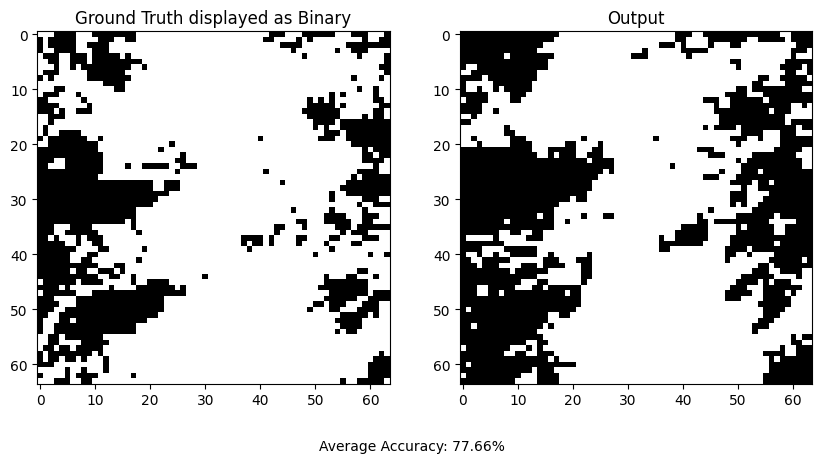

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Display binary ground truth
axs[0].imshow(ground_truth[0], cmap='gray')
axs[0].set_title('Ground Truth displayed as Binary')

# Display output
axs[1].imshow(output[:,timestep][0], cmap='gray')
axs[1].set_title('Output')
plt.figtext(0.5, 0.01, f'Average Accuracy: {average_accuracy * 100:.2f}%', ha='center')

plt.savefig("accuracydemonstration.png")

In [ ]:
from IPython.display import Image, display

for i, (tgt, out) in enumerate(zip(target, output)):       # Loop over samples
    
    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", fps = 5)    
        target_gif = gif.getvalue()

    # Write output video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, out, "GIF", fps = 5)    
        output_gif = gif.getvalue()

    # Display the GIFs using IPython.display.Image
    display(Image(data=target_gif))
    display(Image(data=output_gif))

In [ ]:
torch.save(model.state_dict(), "c_model2.pth")

In [17]:
state_dict = torch.load('CloudModel64.pt')

# Update the model's state dictionary
model.load_state_dict(state_dict)

<All keys matched successfully>